# TOPO E FUNDO DUPLO 2.0

Referência: https://github.com/kelvonlys/Double-Top-and-Bottom/blob/9ac0e9993e23d20bd542137bd4f685d448bbdc9f/mysite/stockAnalysis/views.py

In [1]:
from datetime import date, timedelta
import datetime
import pandas as pd
import numpy as np
import peakutils
import pandas_datareader.data as web
import yfinance as yahoo_finance
from detecta import detect_peaks

In [2]:
result = ""
buy_price = 0
sell_price = 0
rsiPrice = 0
double_top = "No"
double_bottom = "No"
df_reframe = []
today = np.datetime64('today','D')
global transaction_fee
transaction_fee = 0.003443939

In [3]:
def find_spread(self):
    #Spread table from HKEX
    if (0.01 <= self <= 0.25):
        return float(0.001)
    elif  (0.25 < self <= 0.5):
        return float(0.005)
    elif (0.50 < self <= 10.00):
        return float(0.010)
    elif (10.00 < self <= 20.00):
        return float(0.020)
    elif (20.00 < self <= 100.00):
        return float(0.050)
    elif (100.00 < self <= 200.00):
        return float(0.100)
    elif (200.00 < self <= 500.00):
        return float(0.200)
    elif (1000.00 < self <= 2000.00):
        return float(1.000)
    elif (2000.00 < self <= 5000.00):
        return float(2.000)
    else:
        return float(5.000)

def find_vector(self):
    if (0.01 <= self <= 0.25):
        return float(2)
    elif  (0.25 < self <= 0.5):
        return float(1)
    elif (0.50 < self <= 1.00):
        return float(2/10)
    elif (1.00 < self <= 2.00):
        return float(2)
    elif (2.00 < self <= 5.00):
        return float(3)
    elif (5.00 < self <= 10.00):
        return float(5)
    elif (10.00 < self <= 20.00):
        return float(10)
    elif (20.00 < self <= 50.00):
        return float(8)
    elif (50.00 < self <= 70.00):
        return float(10)
    elif (70.00 < self <= 100.00):
        return float(20)
    elif (100.00 < self <= 200.00):
        return float(20)
    elif (200.00 < self <= 500.00):
        return float(20)
    elif (1000.00 < self <= 2000.00):
        return float(10)
    elif (2000.00 < self <= 5000.00):
        return float(220)
    else:
        return float(5.000)


In [4]:
def search_stock (ativo): 
    global spread_price
    global df_reframe
    global spread_vector
    global df

    period_vector = 52*2
    
    ticker = ativo+'.SA'
    start_time = datetime.datetime(2017, 10, 1)
    end_time = datetime.datetime.now().date().isoformat() 
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   
    # use numerical integer index instead of date    
    df_reset = df.reset_index()

    df_reframe = pd.DataFrame(df_reset, columns=['Date', 'High','Low', 'Volume','Adj Close'])
    df_reframe = df_reframe.dropna(how='any')
    df_reframe = df_reframe.to_records(index=False)
    rsiPrice = df['Adj Close']
    
    find_pattern(df_reframe, "Low")
    find_pattern(df_reframe, "High")
    recommendation("Low")
    recommendation("High")
    set_buying_point()
    cal_double_top()
    cal_hold_till()


In [5]:
def get_stock_info ():
    return df_reframe    

def get_max_pairs():
    return max_pairs

def get_min_pairs():
    return min_pairs

def get_sell_price():
    return sell_price

def get_buy_price():
    return buy_price

In [6]:
def find_pattern(obj, x):
    price = np.array(obj[x])
    print("find pattern: ", df_reframe['Low'][0])
    for i in range (0, len(df_reframe)):
        if (df_reframe['Low'][i] < 0.5):
            thres = 0
            break
        else:
            thres = 0.02/max(price)
    print("threshold: ", 0.02/max(price))
    if (x == "Low"):
        indexes = detect_peaks(price, threshold=thres, mpd=1, valley=True)
        bottom_pattern(obj, x, indexes)
    else:
        indexes = detect_peaks(price, threshold=thres, mpd=1) #you can fine tune the thres to smaller value to get even shorter period
        top_pattern(obj, x, indexes)

In [7]:
def top_pattern(obj, x, indexes):
    global max_pairs
    global spread_price
    max_pairs = np.array([],dtype=[('Price', object), ('Volume', object), ('Date', object)])
    for i in range (0, indexes.size):
        #print("indexes: ", obj[indexes[i]][x], "date" , obj[indexes[i]]['Date'])
        for j in range (i + 1, indexes.size):
            num1 = obj[indexes[i]][x]
            num2 = obj[indexes[j]][x]
            date1 = obj[indexes[i]]['Date']
            date2 = obj[indexes[j]]['Date']
            volume1 = obj[indexes[i]]['Volume']
            volume2 = obj[indexes[j]]['Volume']
            if (num1-num2)!= 0: #to handle the case log10(0) which would result in math error 
                #diff = round(abs(num1-num2), -int(floor(log10(abs(num1-num2)))))
                diff = round(abs(num1-num2), 5)
            else:
                diff = abs(num1-num2)
            spread_price = find_spread(num1)*find_vector(num1)
            if (diff <= find_spread(num1)*find_vector(num1)):
                if  (volume1 > volume2): 
                    #print("i: ", num1, " i's volume: ", volume1, "date: ", date1)
                    #print("j: ", num2, 'i volume: ', volume2, "date: ", date2)
                    temp = np.array([((num1, num2),(volume1, volume2), (date1, date2))],dtype=[('Price', object), ('Volume', object), ('Date', object)])
                    max_pairs = np.concatenate((max_pairs, temp))
            elif (num2>num1):
                break
    top_calculation(obj, max_pairs)
    #print("max_pairs", max_pairs)

def top_calculation(obj, max_pairs):
    resistance_period = 1
    success_count = 0
    global success_rate
    success_rate = 0
    for i in range (0, max_pairs.size):
        #print("pairs: ", max_pairs[i]['Date'])
        failure_count = 0
        pair_date = max_pairs[i]['Date'][1]
        for j in range (0, len(obj)):
            if (pair_date <= obj[j]['Date'] <= pair_date + np.timedelta64(resistance_period,'W')):
                #print("date: ", obj[j]['Date'])
                if(obj[j]['High'] > (max_pairs[i]['Price'][1]+find_spread(max_pairs[i]['Price'][1])*find_vector(max_pairs[i]['Price'][1]))):
                    next_higher_price = obj[j]['High']
                    #print("next_higher_price: ", next_higher_price)
                    #print("max price: ", max_pairs[i]['Price'][1])
                    #print("date: ", obj[j]['Date'])
                    failure_count += 1
                    #print("count: ", failure_count)
        if (failure_count == 0):
                #print("SUCCESS: max price: ", max_pairs[i]['Price'][1])
                #print("date: ", max_pairs[i]['Date'][1])
                success_count += 1
    print("sucess count: ", success_count)
    if (success_count!=0):
        success_rate = (success_count*100/max_pairs.size)
    print("success_rate: ",success_rate)

In [8]:
def bottom_pattern(obj, x, indexes):
    global min_pairs
    min_pairs = np.array([],dtype=[('Price', object), ('Volume', object), ('Date', object)])
    for i in range (0, indexes.size):
        #print("indexes: ", obj[indexes[i]][x], "date" , obj[indexes[i]]['Date'])
        for j in range (i + 1, indexes.size):
            num1 = obj[indexes[i]][x]
            num2 = obj[indexes[j]][x]
            date1 = obj[indexes[i]]['Date']
            date2 = obj[indexes[j]]['Date']
            volume1 = obj[indexes[i]]['Volume']
            volume2 = obj[indexes[j]]['Volume']
            if (num1-num2)!= 0: #to handle the case log10(0) which would result in math error 
                #diff = round(abs(num1-num2), -int(floor(log10(abs(num1-num2)))))
                diff = round(abs(num1-num2), 5)
            else:
                diff = abs(num1-num2)
            if (diff <= find_spread(num1)*find_vector(num1)):
                if  (volume1 > volume2): 
                    #print("i: ", num1, " i's volume: ", volume1, "date: ", date1)
                    #print("j: ", num2, 'i volume: ', volume2, "date: ", date2)
                    temp = np.array([((num1, num2),(volume1, volume2), (date1, date2))],dtype=[('Price', object), ('Volume', object), ('Date', object)])
                    min_pairs = np.concatenate((min_pairs, temp))
            elif (num2<num1):
                #print("when num1 > num2, i: ", num1, " i's volume: ", volume1, "date: ", date1)
                #print("when num1 > num2, j: ", num2, 'i volume: ', volume2, "date: ", date2)
                break
    bottom_calculation(obj, min_pairs)
    print("min_pairs", min_pairs)

def bottom_calculation(obj, min_pairs):
    resistance_period = 1
    success_count = 0
    global bottom_success_rate
    bottom_success_rate = 0
    
    for i in range (0, min_pairs.size):
        #print("pairs: ", min_pairs[i]['Date'])
        failure_count = 0
        pair_date = min_pairs[i]['Date'][1]
        for j in range (0, len(obj)):
            if (pair_date <= obj[j]['Date'] <= pair_date + np.timedelta64(resistance_period,'W')):
                #print("date: ", obj[j]['Date'])
                if(obj[j]['Low'] < (min_pairs[i]['Price'][1]-find_spread(min_pairs[i]['Price'][1])*find_vector(min_pairs[i]['Price'][1]))):
                    next_higher_price = obj[j]['Low']
                    #print("next_lower_price: ", next_higher_price)
                    #print("max price: ", min_pairs[i]['Price'][1])
                    #print("lower date: ", obj[j]['Date'])
                    failure_count += 1
                    #print("count: ", failure_count)
        if (failure_count == 0):
                #print("max price: ", min_pairs[i]['Price'][1])
                #print("date: ", min_pairs[i]['Date'][1])
                success_count += 1
    print("bottom sucess count: ", success_count)
    if (success_count!=0):
        bottom_success_rate = (success_count*100/min_pairs.size)
    print("bottom success_rate: ",bottom_success_rate)


In [9]:
def set_buying_point():
    global buying_points
    buying_points = np.array([],dtype=[('Price', object), ('Date', object)])
    for i in range (0, min_pairs.size):
        temp_obj = transaction_date_adder(min_pairs[i]['Date'][1], 1)
        temp = np.array([(temp_obj['Low'], temp_obj['Date'])],dtype=[('Price', object), ('Date', object)])
        buying_points = np.concatenate((buying_points, temp))
    #print("buying_points: ",buying_points) 

def transaction_date_adder(date, period_to_be_added):
    for i in range (0, len(df_reframe)):
        if (date == df_reframe['Date'][i]):
            return df_reframe[i+1]

In [10]:
def cal_double_top():
    global double_top_profit_average
    global double_top_profit
    double_top_profit_average = 0
    double_top_profit = 0
    double_top_sum = 0
    temp_buying_points = np.copy(buying_points)

    for i in range (0, temp_buying_points.size):
        if (temp_buying_points[i]['Price'] == 0):
            continue
        for j in range (0, max_pairs.size):
            if (max_pairs[j]['Date'][1] >= temp_buying_points[i]['Date']):
                    selling_price = transaction_date_adder(max_pairs[j]['Date'][1], 1)['Low']
                    total_fee = transaction_fee*(sell_price + temp_buying_points[i]['Price'])
                    double_top_profit = double_top_profit + (selling_price - temp_buying_points[i]['Price'] - total_fee)*100/temp_buying_points[i]['Price']
       
                    break
            elif (j == max_pairs.size-1):
                selling_price = df_reframe[df_reframe.size-1]['Low']
                total_fee = transaction_fee*(sell_price + temp_buying_points[i]['Price'])
                double_top_profit = double_top_profit + (selling_price - temp_buying_points[i]['Price'] - total_fee)*100/temp_buying_points[i]['Price']
          
    if (temp_buying_points.size > 0):
        double_top_profit_average = double_top_profit/temp_buying_points.size
    print("double_top_profit %: ", double_top_profit_average)
    print("sum: ", double_top_profit)


In [11]:
def cal_hold_till():
    global hold_till_profit_average
    global hold_till_profit
    hold_till_profit_average = 0
    hold_till_profit = 0
    hold_till_sum = 0
    for i in range (0, buying_points.size):
        #selling_price = transaction_date_adder(buying_points[i]['Date'], 13)['High']
        selling_price = df_reframe[df_reframe.size-1]['Low']
        total_fee = transaction_fee*(sell_price + buying_points[i]['Price'])
        #hold_till_profit = hold_till_profit + (selling_price - buying_points[i]['Price']) - total_fee
        hold_till_profit = hold_till_profit + (selling_price - buying_points[i]['Price'] - total_fee)*100/buying_points[i]['Price']
        #print("hold_till_profit: ", hold_till_profit, "date: ", buying_points[i]['Date'])
        #print("hold_till_sum: ", hold_till_sum)
    if (buying_points.size > 0):
        hold_till_profit_average = hold_till_profit/buying_points.size
    print("hold_till_profit: ", hold_till_profit_average)
    print("hold-till sum: ", hold_till_profit)

In [19]:
def recommendation(x):  #reverse recommendation would be faster
    #this should only calculate things within three months
    global buy_price
    global sell_price
    global double_top
    global double_bottom
    global recom_bottom
    global loop_breaker

    loop_breaker = False

    recom_bottom = np.array([],dtype=[('Price', object), ('Date', object), ('Type', object)])
    recommended_period = 52
    ticker = 'ITSA4.SA'
    start_time = datetime.datetime(2017, 10, 1)
    end_time = datetime.datetime.now().date().isoformat() 
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   
    # use numerical integer index instead of date    
    df_reset = df.reset_index()

    df_reframe = pd.DataFrame(df_reset, columns=['Date', 'High','Low', 'Volume','Adj Close'])
    df_reframe = df_reframe.dropna(how='any')
    df_reframe = df_reframe.to_records(index=False)
    rsiPrice = df['Adj Close']
    obj = pd.DataFrame(df_reset, columns=['Date', 'High','Low', 'Volume','Adj Close'])
    obj = obj.dropna(how='any')
    obj = obj.to_records(index=False)
    price = np.array(obj[x])
    new_indexes = np.array([])

    if (x == "Low"):
        indexes = detect_peaks(price, threshold=0.02/max(price), mpd=1, valley=True)
    else:
        indexes = detect_peaks(price, threshold=0.02/max(price), mpd=1) #you can fine tune the thres to smaller value to get more peaks

    for i in reversed (indexes):
        new_indexes = np.append(new_indexes, int(i))

    
    for i in range (0, new_indexes.size): ##### the array is reversed here, started from the most recent date
        indexes1 = int(new_indexes[i])
        for j in range (i + 1, new_indexes.size):
            indexes2 = int(new_indexes[j])
            reverse_num1 = obj[indexes1][x]
            reverse_num2 = obj[indexes2][x]
            volume1 = obj[indexes1]['Volume']
            volume2 = obj[indexes2]['Volume']
            date1 = obj[indexes1]['Date']
            date2 = obj[indexes2]['Date']
            print("High/Low? ", x)
            print("i: ", reverse_num1, " i's volume: ", volume1, "date: ", date1)
            print("j: ", reverse_num2, 'i volume: ', volume2, "date: ", date2)
            if (reverse_num1 - reverse_num2)!= 0: #to handle the case log10(0) which would result in math error 
                #diff = round(abs(reverse_num1-reverse_num2), -int(floor(log10(abs(reverse_num1-reverse_num2)))))
                diff = round(abs(reverse_num1-reverse_num2), 5)
            else:
                diff = abs(reverse_num1-reverse_num2)
            if (x == "Low"):
                if (diff <= find_spread(reverse_num1)*find_vector(reverse_num1)):
                    if  (volume1 < volume2): 
                        temp = min(reverse_num1, reverse_num2) ### more checking here
                        double_bottom = "Yes"
                        print("buy_price: ",temp)
                        print("df_reframe: ",df_reframe[df_reframe.size-1]['Low'] )
                        if (temp <= df_reframe[df_reframe.size-1]['Low']):
                            buy_price = temp
                            print("low", df_reframe[df_reframe.size-1]['Low'])
                            loop_breaker = True
                            break
                    else:
                        temp = min(reverse_num1, reverse_num2)
                        double_bottom = "Double trough but without volume"
                        if (temp <= df_reframe[df_reframe.size-1]['Low']):
                            buy_price = temp
                            loop_breaker = True
                            break
                elif(diff > find_spread(reverse_num1)*find_vector(reverse_num1)): #this should be short term: within 3months (should deal with this later!!!)
                    single_bottom(obj, new_indexes)
                    if (loop_breaker == True):
                        break
                
                elif (reverse_num1 > reverse_num2):
                    break
                
            else: # (x == "High")
                if (diff <= find_spread(reverse_num1)*find_vector(reverse_num1)):
                    if  (volume1 < volume2): 
                        temp_sell = max(reverse_num1,reverse_num2)
                        double_top = "Yes"
                        print("double top: Yes")
                        if (temp_sell >= df_reframe[df_reframe.size-1]['High']):
                            sell_price = temp_sell
                            loop_breaker = True
                            break
                    else:
                        temp_sell = max(reverse_num1,reverse_num2)
                        double_top = "Double peak but without volume"
                        if (temp_sell >= df_reframe[df_reframe.size-1]['High']):
                            sell_price = temp_sell
                            loop_breaker = True
                            break
                elif (diff > find_spread(reverse_num1)*find_vector(reverse_num1)):
                    single_top(obj, new_indexes)
                    if (loop_breaker == True):
                        break

                elif (reverse_num1 < reverse_num2):
                    break
            print("loop_breaker outside: ", loop_breaker)
        if (loop_breaker == True):
            break
    
    if (min_pairs.size > 0 and buy_price == min_pairs[min_pairs.size-1]['Price'][1]):
        double_bottom = "Yes"
    if (max_pairs.size > 0 and sell_price == max_pairs[max_pairs.size-1]['Price'][1]):
        double_top = "Yes"

In [16]:
def single_top (obj, indexes):
    global sell_price
    global double_top 
    global loop_breaker

    for i in range (0, indexes.size):
        indexes1 = int(indexes[i])
        adjusted_price = obj[indexes1]['High']
        volume1 = obj[indexes1]['Volume']
        for k in range (0, len(obj)):
            if (obj[k]['Date'] < obj[indexes1]['Date']): #if date does not match, go to next loop , loop++
                continue

            '''    ###### this is to make sure the recent double top only compares the latest high, this function should stop after two peaks have been looped, test the stock 00083 (date range same as fyp report), also the break should only break this function and the double top pattern should keep on looping
            if (obj[k]['Date'] < obj[int(indexes[0])]['Date']): 
                loop_breaker = True
                break'''

            norm_price = obj[k]['High']
            volume2 = obj[k]['Volume']
            if (adjusted_price-norm_price)!= 0: #to handle the case log10(0) which would result in math error 
                diff = round(abs(adjusted_price-norm_price), 5)
            else:
                diff = abs(adjusted_price-norm_price)

            if (diff <= find_spread(adjusted_price)*find_vector(adjusted_price)):
                if  (volume1 > volume2): 
                    temp_sell = max(adjusted_price,norm_price)
                    double_top = "Yes, it is a recent double top"
                    #print("num1: ", adjusted_price, " i's volume: ", volume1, "date: ", obj[indexes1]['Date'], "norm_price: ", norm_price, "Norm date: ",obj[k]['Date'])
                    #print("recent double top: Yes")
                    if (temp_sell >= df_reframe[df_reframe.size-1]['High']):
                        sell_price = temp_sell2
                        loop_breaker = True
                        break
                else:
                    temp_sell = max(adjusted_price,norm_price)
                    double_top = "Recent double top but without volume"
                    #print("loop break: ", loop_breaker)
                    if (temp_sell >= df_reframe[df_reframe.size-1]['High']):
                        sell_price = temp_sell
                        loop_breaker = True
                        break
            else:
                temp_sell = max(adjusted_price, norm_price)
                double_top = "No double top pattern is detected, recommendation made according to the peak detected"
                if (temp_sell >= df_reframe[df_reframe.size-1]['High']):
                    sell_price = temp_sell
                    loop_breaker = True
                    break
        if (loop_breaker == True):
            break

def single_bottom (obj, indexes):
    global buy_price
    global double_bottom
    global loop_breaker
    for i in range (0, indexes.size):
        indexes1 = int(indexes[i])
        adjusted_price = obj[indexes1]['Low']
        volume1 = obj[indexes1]['Volume']
        for k in range (0, len(obj)):
            if (obj[k]['Date'] < obj[indexes1]['Date']): #if date does not match, go to next loop , loop++
                continue

            '''    ###### this is to make sure the recent double top only compares the latest high, this function should stop after two peaks have been looped, test the stock 00083 (date range same as fyp report), also the break should only break this function and the double top pattern should keep on looping
            if (obj[k]['Date'] < obj[int(indexes[0])]['Date']): 
                loop_breaker = True
                break'''

            norm_price = obj[k]['Low']
            volume2 = obj[k]['Volume']
            if (adjusted_price-norm_price)!= 0: #to handle the case log10(0) which would result in math error 
                diff = round(abs(adjusted_price-norm_price), 5)
            else:
                diff = abs(adjusted_price-norm_price)

            if (diff <= find_spread(adjusted_price)*find_vector(adjusted_price)):
                if  (volume1 > volume2): 
                    temp_buy = min(adjusted_price,norm_price)
                    double_bottom = "Yes, it is a recent double bottom"
                    #print("num1: ", adjusted_price, " i's volume: ", volume1, "date: ", obj[indexes1]['Date'], "norm_price: ", norm_price, "Norm date: ",obj[k]['Date'])
                    #print("recent double bottom: Yes")
                    if (temp_buy <= df_reframe[df_reframe.size-1]['Low']):
                        buy_price = temp_buy
                        loop_breaker = True
                        break
                else:
                    temp_buy = min(adjusted_price,norm_price)
                    double_bottom = "Recent double bottom but without volume"
                    print("loop break: ", loop_breaker)
                    if (temp_buy <= df_reframe[df_reframe.size-1]['Low']):
                        buy_price = temp_buy
                        loop_breaker = True
                        print("loop break: ", loop_breaker)
                        break
            else:
                temp_buy = min(adjusted_price, norm_price)
                double_bottom = "No double bottom pattern is detected, recommendation made according to the trough detected"
                if (temp_buy <= df_reframe[df_reframe.size-1]['Low']):
                    buy_price = temp_buy
                    loop_breaker = True
                    break
        if (loop_breaker == True):
            break


In [20]:
search_stock('ITSA4')

connected to yahoo
find pattern:  9.918181419372559
threshold:  0.0014164306063808511
bottom sucess count:  129
bottom success_rate:  80.12422360248448
min_pairs [((10.090909004211426, 10.009090423583984), (12257960.0, 11773960.0), (numpy.datetime64('2017-10-09T00:00:00.000000000'), numpy.datetime64('2017-10-19T00:00:00.000000000')))
 ((9.327272415161133, 9.345454216003418), (23333750.0, 21098660.0), (numpy.datetime64('2017-11-07T00:00:00.000000000'), numpy.datetime64('2017-11-14T00:00:00.000000000')))
 ((9.327272415161133, 9.372727394104004), (23333750.0, 11761970.0), (numpy.datetime64('2017-11-07T00:00:00.000000000'), numpy.datetime64('2017-11-16T00:00:00.000000000')))
 ((9.327272415161133, 9.318181037902832), (23333750.0, 15163720.0), (numpy.datetime64('2017-11-07T00:00:00.000000000'), numpy.datetime64('2017-12-01T00:00:00.000000000')))
 ((9.327272415161133, 9.327272415161133), (23333750.0, 20313370.0), (numpy.datetime64('2017-11-07T00:00:00.000000000'), numpy.datetime64('2017-12-07

sucess count:  187
success_rate:  76.3265306122449
connected to yahoo
High/Low?  Low
i:  11.09000015258789  i's volume:  36679200.0 date:  2021-10-06T00:00:00.000000000
j:  11.0600004196167 i volume:  34346900.0 date:  2021-10-04T00:00:00.000000000
loop_breaker outside:  False
High/Low?  Low
i:  11.09000015258789  i's volume:  36679200.0 date:  2021-10-06T00:00:00.000000000
j:  10.890000343322754 i volume:  45330900.0 date:  2021-09-27T00:00:00.000000000
buy_price:  10.890000343322754
df_reframe:  0.0
loop_breaker outside:  False
High/Low?  Low
i:  11.09000015258789  i's volume:  36679200.0 date:  2021-10-06T00:00:00.000000000
j:  10.5600004196167 i volume:  54805500.0 date:  2021-09-20T00:00:00.000000000
loop break:  False
loop break:  False
connected to yahoo
High/Low?  High
i:  11.479999542236328  i's volume:  38280500.0 date:  2021-10-08T00:00:00.000000000
j:  11.4399995803833 i volume:  38860600.0 date:  2021-10-05T00:00:00.000000000
double top: Yes
double_top_profit %:  9.4097748

In [55]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.dates import DateFormatter

def graphic():

    df = get_stock_info()
    max_pairs = get_max_pairs()
    min_pairs = get_min_pairs()
    buy_price = get_buy_price()
    sell_price = get_sell_price()

    fig=Figure(figsize=[25, 10],facecolor='#f6f6f6')
    ax=fig.add_subplot(111)
    x=df['Date']
    now=datetime.datetime.now()
    delta=datetime.timedelta(days=1)
    
    ax.plot_date(x, df['Low'], '-', color = '#BF463F')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.plot_date(x, df['High'], '-', color = '#1971E5')
    
    ax.axhline(y=buy_price, color='k')
    ax.axhline(y=sell_price, color='k')

    for i in range (0, max_pairs.size):
        ax.scatter(x=max_pairs[i]['Date'][0], y=max_pairs[i]['Price'][0], marker= 'x', color='r')
        ax.scatter(x=max_pairs[i]['Date'][1], y=max_pairs[i]['Price'][1], marker= 'x', color='r')

    for j in range (0, min_pairs.size):
        #ax.axvline(x=min_pairs[j]['Date'][0], color='#0F892B', linewidth=0.5)
        #ax.axvline(x=min_pairs[j]['Date'][1], color='#D4CD06')

        ax.scatter(x = min_pairs[j]['Date'][0], y=min_pairs[j]['Price'][0], marker= 'x', color='r')
        ax.scatter(x = min_pairs[j]['Date'][1], y=min_pairs[j]['Price'][1], marker= 'x', color='r')
    
    return fig

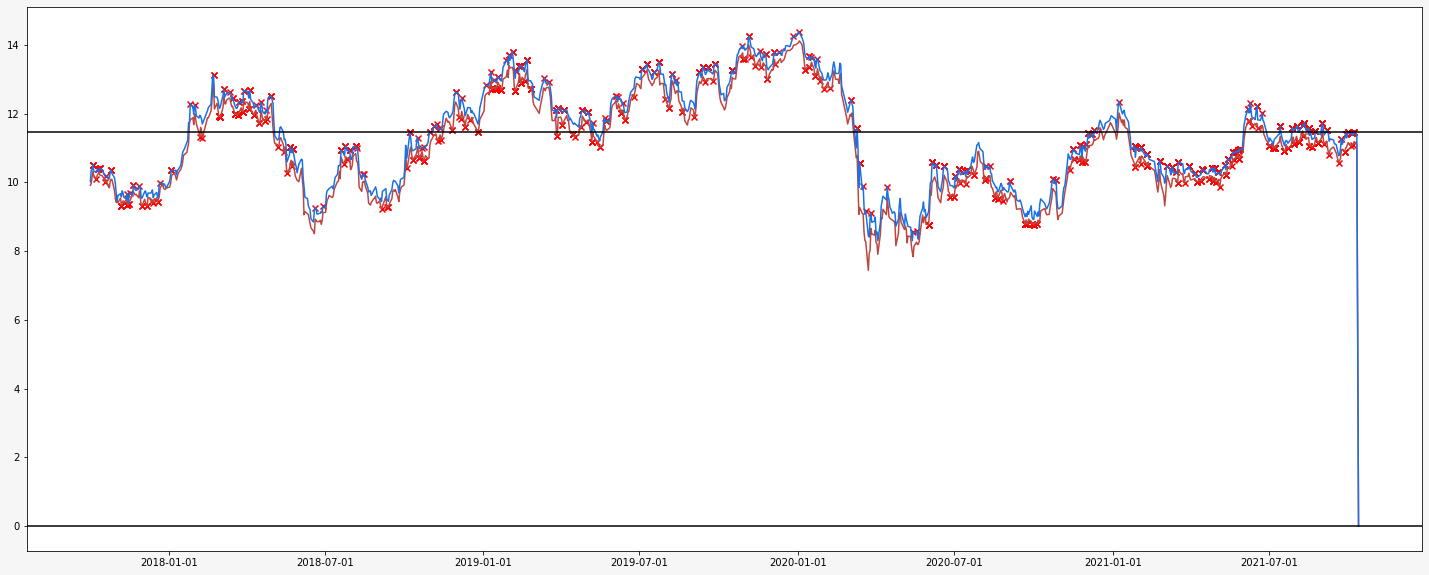

In [56]:
fig = graphic()
fig